# Predict

## model

In [1]:
import json
import torch
with open("ConformerCTCSmall.json") as json_config:
    config = json.load(json_config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [2]:
from functions import *
# Create Model
model = create_model(config).to(device)

In [3]:
model.eval()

ModelCTC(
  (encoder): ConformerEncoder(
    (preprocessing): AudioPreprocessing(
      (Spectrogram): Spectrogram()
      (MelScale): MelScale()
    )
    (augment): SpecAugment()
    (subsampling_module): Conv2dSubsampling(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(1, 176, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(176, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Swish()
        )
        (1): Sequential(
          (0): Conv2d(176, 176, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(176, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Swish()
        )
      )
    )
    (padding_mask): StreamingMask(
      (padding_mask): PaddingMask()
    )
    (linear): Linear(in_features=3520, out_features=176, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (blocks): ModuleList(
      (0): ConformerBlock(
        (feed_for

In [4]:
model.load("./callbacks/ConformerCTCSmall/checkpoints_7.ckpt")

model loaded at step 311 / lr 0.000047


## data

In [5]:
from torch.utils.data import DataLoader
from utils.datasets import collate_fn_pad, AshellDataset
dev_dataset = AshellDataset('./data/aishell/wav', split='dev')
dev_loader = DataLoader(
    dev_dataset, 
    batch_size=8, 
    shuffle=True, 
    collate_fn=collate_fn_pad, 
)

In [7]:
for batch in dev_loader:
    inputs, targets, input_lengths, target_lengths = batch
    break

In [14]:
inputs.shape # [batch, seq_len]

torch.Size([8, 67680])

In [17]:
input_lengths

tensor([67680, 66752, 65008, 55152, 47328, 43713, 40816, 37519])

## Forward

### encoder

In [13]:
from torchinfo import summary
summary(model.encoder, input_data=(inputs, input_lengths))

Layer (type:depth-idx)                                                 Output Shape              Param #
ConformerEncoder                                                       [8, 106, 176]             --
├─AudioPreprocessing: 1-1                                              [8, 80, 424]              --
│    └─Spectrogram: 2-1                                                [8, 257, 424]             --
│    └─MelScale: 2-2                                                   [8, 80, 424]              --
├─Conv2dSubsampling: 1-2                                               [8, 3520, 106]            --
│    └─ModuleList: 2-3                                                 --                        --
│    │    └─Sequential: 3-1                                            [8, 176, 40, 212]         2,112
│    │    └─Sequential: 3-2                                            [8, 176, 20, 106]         279,312
├─StreamingMask: 1-3                                                   [8, 1, 106, 106]

In [16]:
inputs[0], targets[0]

(tensor([ 0.0000e+00, -6.1035e-05, -6.1035e-05,  ..., -9.1553e-05,
         -9.1553e-05, -6.1035e-05]),
 tensor([ 72,  21,  20, 621, 695,  91, 425, 385, 156,  46,  41,  33, 168, 684,
         369,  29, 536,  76, 707,  73]))

In [25]:
from utils.tokenizer import Vocabulary
vocab = Vocabulary.load("./data/aishell/vocab.txt")
" ".join(vocab.to_tokens(targets[0].tolist()))

'也 是 在 遭 遇 金 融 变 化 和 行 业 利 润 率 不 断 下 跌 后'

In [18]:
logits, logits_len, attentions = model.encoder(inputs, input_lengths)

In [21]:
attentions[0].shape

torch.Size([8, 4, 106, 106])

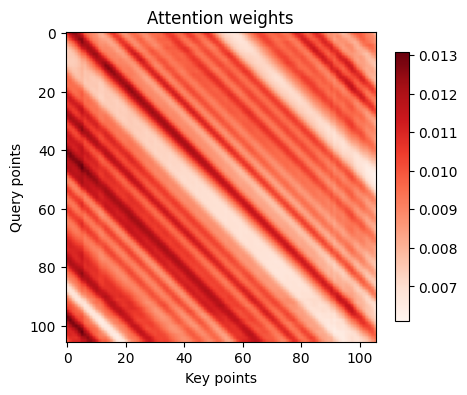

In [22]:
from utils.draw import show_attention
conformer_blocks_index = -1
batch_index = 0
head_index = 0
show_attention(
    attentions[conformer_blocks_index][batch_index][head_index]
)

In [26]:
logits.shape, logits_len # (batch, T, dim_model), (batch)

(torch.Size([8, 106, 176]), tensor([106, 105, 102,  87,  74,  69,  64,  59]))

### fc

In [27]:
summary(model.fc, input_data=logits)

Layer (type:depth-idx)                   Output Shape              Param #
Linear                                   [8, 106, 4350]            769,950
Total params: 769,950
Trainable params: 769,950
Non-trainable params: 0
Total mult-adds (M): 6.16
Input size (MB): 0.60
Forward/backward pass size (MB): 29.51
Params size (MB): 3.08
Estimated Total Size (MB): 33.19

In [28]:
logits = model.fc(logits) # (batch, T, dim_model) -> (batch, T, vocab_size)

In [29]:
logits.shape # (batch, T, vocab_size)

torch.Size([8, 106, 4350])

### greedy search

In [30]:
# Softmax -> Log > Argmax -> (B, T)
preds = logits.log_softmax(dim=-1).argmax(dim=-1)

In [31]:
preds.shape # (batch, T)

torch.Size([8, 106])

In [34]:
# Batch Pred List
batch_pred_list = []

# Batch loop
for i in range(preds.shape[0]):

    # Blank
    blank = False

    # Pred List
    pred_list = []

    # Decoding Loop
    for j in range(logits_len[i]):
        if preds[i, j] == 0:
            continue

        # First Prediction
        if len(pred_list) == 0:
            pred_list.append(preds[i, j].item())

        # New Prediction
        elif pred_list[-1] != preds[i, j] or blank:
            pred_list.append(preds[i, j].item())
        
        # Update Blank
        blank = False

    # Append Sequence
    batch_pred_list.append(pred_list)

# Decode Sequences
for item in batch_pred_list:
    print(" ".join(model.tokenizer.to_tokens(item)))
